In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip show equinox || echo equinox not found. Installing... && pip install equinox 2> /dev/null

Name: equinox
Version: 0.11.2
Summary: Elegant easy-to-use neural networks in JAX.
Home-page: 
Author: 
Author-email: Patrick Kidger <contact@kidger.site>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by cont

Some additional useful code from previous notebooks:

In [49]:
import jax
import equinox as eqx

class FourierEncoding(eqx.Module):
    B: jax.Array

    @property
    def num_fourier_features(self) -> int:
        return self.B.shape[0]

    @property
    def in_size(self) -> int:
        return self.B.shape[1]
    
    @property
    def out_size(self) -> int:
        return self.B.shape[0] * 2

    def __init__(self, 
                 in_size: int, 
                 num_fourier_features: int, 
                 key: jax.random.PRNGKey, 
                 sigma: float = 1.0):
        self.B = jax.random.normal(
            key, shape=(num_fourier_features, in_size),
            dtype=jax.numpy.float32) * sigma
    
    def __call__(self, x: jax.Array, **kwargs) -> jax.Array:
        return jax.numpy.concatenate(
            [jax.numpy.cos(jax.numpy.dot(self.B, x)),
             jax.numpy.sin(jax.numpy.dot(self.B, x))],
            axis=0)
    

def train_pinn(
        loss,
        fourier_mlp,
        key,
        optimizer,
        filter_spec,
        Lx=1.0,
        Ly=1.0,
        num_collocation_residual=512,
        num_iter=10_000,
        freq=1,
    ):

    # this is new
    def new_loss(diff_model, static_model, x, y):
        comb_model = eqx.combine(diff_model, static_model)
        return loss(comb_model, x, y)

    @eqx.filter_jit
    def step(opt_state, model, xs, ys):
        # added this line
        diff_model, static_model = eqx.partition(model, filter_spec)
        # changed the loss to the new loss
        value, grads = eqx.filter_value_and_grad(new_loss)(diff_model, static_model, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(fourier_mlp, eqx.is_inexact_array))
    
    losses = []
    for i in range(num_iter):
        key1, key2, key = jrandom.split(key, 3)
        xb = jrandom.uniform(key1, (num_collocation_residual,), maxval=Lx)
        yb = jrandom.uniform(key2, (num_collocation_residual,), maxval=Ly)
        fourier_mlp, opt_state, value = step(opt_state, fourier_mlp, xb, yb)
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return fourier_mlp, losses

# Random Weight Factorization

The idea in Wang et al. (2022) is to factorize the weights of an MLP as follows:

$$
\mathbf{W}^{(l)} = \operatorname{diag}\left(\exp\left\{\mathbf{s}^{(l)}\right\}\right) \mathbf{V}^{(l)},
$$

where each exponentiated element $\exp\left\{s_i^{(l)}\right\}$ of the diagonal matrix $\mathbf{s}^{(l)}$ is a random number sampled from a normal distribution $\mathcal{N}(\mu,\sigma)$.
The matrix $\mathbf{V}^{(l)}$ is not directly initialized.
Instead, one initializes $\mathbf{W}^{(l)}$ with a standard initialization method (e.g. Xavier or He) and then factorizes it as above.

Let's implement this.

In [60]:
import jax
import jax.numpy as jnp

class LinearRWF(eqx.Module):
    s: jax.Array
    V: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, mu=0.5, sigma=0.1):
        self.s = mu + sigma * jax.random.normal(key, shape=(out_size,), dtype=jax.numpy.float32)
        initializer = jax.nn.initializers.glorot_normal()
        W = initializer(key, (out_size, in_size))
        self.V = jnp.einsum('i,ij->ij', jnp.exp(-self.s), W)
        self.bias = jnp.zeros(out_size)
    
    def __call__(self, x: jax.Array, **kwargs) -> jax.Array:
        return jnp.einsum('i,ij,j->i', jnp.exp(self.s), self.V, x) + self.bias

In [67]:
import jax.random as jrandom

def MLPRWF(in_size, out_size, width, depth, activation, key, final_activation=None, **rwf_kwargs):
    keys = jrandom.split(key, depth + 1)
    layers = [LinearRWF(in_size, width, keys[0], **rwf_kwargs)]
    for i in range(depth-2):
        layers.append(eqx.nn.Lambda(activation))
        layers.append(LinearRWF(width, width, keys[i], **rwf_kwargs))
    layers.append(eqx.nn.Lambda(activation))
    layers.append(LinearRWF(width, out_size, keys[-1], **rwf_kwargs))
    if final_activation is not None:
        layers.append(eqx.nn.Lambda(final_activation))
    return eqx.nn.Sequential(layers)

In [76]:
from jax import grad, vmap
import jax.tree_util as jtu
key = jrandom.PRNGKey(0)

u0 = 500 # degrees Kelvin
k = 10.0 # thermal conductivity in W/mK
Lx = 0.1 # meters
Ly = 1.0 # meters

to_x = lambda xt: xt * Lx
to_y = lambda yt: yt * Ly
to_xt = lambda x: x / Lx
to_yt = lambda y: y / Ly

source_term = lambda x, y: 2.0 * jnp.pi ** 2 * k * u0 * (
    -Lx ** 2 * jnp.sin(jnp.pi * x / Lx) ** 2 * jnp.cos(2.0 * jnp.pi * y / Ly)
    -Ly ** 2 * jnp.sin(jnp.pi * y / Ly) ** 2 * jnp.cos(2.0 * jnp.pi * x / Lx)
) / (Lx ** 2 * Ly ** 2)

key1, key2, key = jrandom.split(key, 3)
num_fourier_features = 128
width = 256
depth = 4

model = eqx.nn.Sequential([
    FourierEncoding(2, num_fourier_features, key1),
    MLPRWF(num_fourier_features * 2, 1, width, depth, jax.nn.tanh, key2),
    eqx.nn.Lambda(lambda y: y[0])])

# remember that we need a way to filter out the parameters of the Fourier encoding
filter_spec = jtu.tree_map(lambda _: True, model)
filter_spec = eqx.tree_at(
    lambda tree: (tree[0].B,),
    filter_spec,
    replace=(False,))

# The model that satisfies the boundary conditions
u_hat = lambda x, y, model: x * (1.0 - x) * y * (1.0 - y) * model(jnp.array([x, y]))
u_x = grad(u_hat, 0)
u_y = grad(u_hat, 1)
u_xx = grad(u_x, 0)
u_yy = grad(u_y, 1)

# We need to find new scaling factors because the network structure has changed
v_u_xx = eqx.filter_jit(eqx.filter_vmap(u_xx, in_axes=(0, 0, None)))
v_u_yy = eqx.filter_jit(eqx.filter_vmap(u_yy, in_axes=(0, 0, None)))
x = jnp.linspace(0, Lx, 100)
y = jnp.linspace(0, Ly, 100)
X, Y = jnp.meshgrid(x, y)
Xt = to_xt(X)
Yt = to_yt(Y)
max_u_xx = jnp.abs(v_u_xx(Xt.flatten(), Yt.flatten(), model)).max()
max_u_yy = jnp.abs(v_u_yy(Xt.flatten(), Yt.flatten(), model)).max()

# Calculate the scale:
fs = 9.96e+06
us = fs / k / max(max_u_xx, max_u_yy) / max(1/Lx**2, 1/Ly**2)
tkx = (k * us) / (Lx ** 2 * fs)
tky = (k * us) / (Ly ** 2 * fs)

print(f"Scale factor fs: {fs:.2e}")
print(f"Scale factor us: {us:.2e}")
print(f"tkx = {tkx:.3e}, tky = {tky:.3e}") 

tilde_source_term = lambda tx, ty: source_term(to_x(tx), to_y(ty)) / fs

pde_residual = vmap(
    lambda x, y, model: tkx * u_xx(x, y, model) + tky * u_yy(x, y, model) + tilde_source_term(x, y),
    in_axes=(0, 0, None))
pinn_loss = lambda model, x, y: jnp.mean(jnp.square(pde_residual(x, y, model)))

Scale factor fs: 9.96e+06
Scale factor us: 1.51e+04
tkx = 1.519e+00, tky = 1.519e-02


In [78]:
import optax

key, subkey = jax.random.split(key)
optimizer = optax.adam(1e-3)
trained_model, losses = train_pinn(
    pinn_loss, model, key, optimizer, filter_spec,
    num_collocation_residual=256, num_iter=2_000, freq=100, Lx=1.0, Ly=1.0)

Step 0, residual loss 2.757e-01
Step 100, residual loss 1.249e-03
Step 200, residual loss 1.802e-04
Step 300, residual loss 1.096e-03
Step 400, residual loss 2.484e-04
Step 500, residual loss 1.618e-02
Step 600, residual loss 1.120e-04
Step 700, residual loss 7.340e-05
Step 800, residual loss 4.082e-05
Step 900, residual loss 2.381e-05
Step 1000, residual loss 2.982e-05
Step 1100, residual loss 6.858e-06
Step 1200, residual loss 1.207e-04
Step 1300, residual loss 1.390e-05
Step 1400, residual loss 4.407e-05
Step 1500, residual loss 2.277e-05
Step 1600, residual loss 1.031e-04
Step 1700, residual loss 2.795e-04
Step 1800, residual loss 6.030e-04
Step 1900, residual loss 1.343e-05


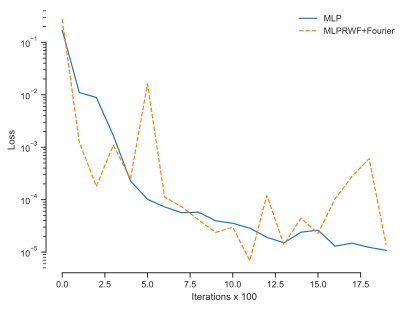

In [80]:
import numpy as np
mlp_losses = np.load("mlp_losses.npz")["losses"]
fig, ax = plt.subplots()
ax.plot(mlp_losses, label="MLP")
ax.plot(losses, '--', label="MLPRWF+Fourier")
# set log scale for y axis
ax.set_yscale('log')
ax.set_xlabel("Iterations x 100")
ax.set_ylabel("Loss")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);